# *Etapa 2: Engenharia de Features (profile.json)*

Ao término do processamento, devemos ter as seguintes variáveis:

* ``client_id``: código de identificação do cliente    
* ``registered_on``: data de criação da conta
* ``registered_duration_days``: tempo de relacionamento em dias
* ``registered_duration_month``: tempo de relacionamento em meses
* ``registered_duration_years``: tempo de relacionamento em anos
* ``gender``: gênero do cliente
* ``gender_M``: variável dummy para indicar o gênero masculino 'M'
* ``gender_F``: variável dummy para indicar o gênero feminino 'F'
* ``gender_O``: variável dummy para indicar o gênero outros 'O'
* ``gender_U``: variável dummy para indicar o gênero desconhecido 'U'
* ``age``: idade do cliente na criação da conta
* ``age_group``: grupo de idades de 10 em 10 anos
* ``age_group_index``: identificador para o grupo de idade
* ``credit_card_limit``: limite do cartão registrado
* ``category_limite``: indicador de renda do cliente (1=renda menor, 5=renda maior)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 15:52:56 WARN Utils: Your hostname, N0L144853, resolves to a loopback address: 127.0.1.1; using 192.168.3.112 instead (on interface wlp0s20f3)
25/08/10 15:52:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/10 15:52:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/10 15:52:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/08/10 15:52:57 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/08/10 15:52:57 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/08/10 15:52:57 WARN Utils

In [2]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import plotly.express as px

import random

#random sampling
def random_limit(limit):
    if limit is None:
        return int(random.choice(valid_limit))
    else:
        return int(limit)
    
def random_age(age):
    if age == 118 or age is None:
        return int(random.choice(valid_ages))
    else:
        return int(age)
    
random_limit_udf = F.udf(random_limit, T.IntegerType())
random_age_udf = F.udf(random_age, T.IntegerType())

# Read Files

In [3]:
path_json = "../data/raw/profile.json"
output_table = "../data/trusted/profile"

schema = T.StructType([
            T.StructField("age", T.IntegerType(), True),
            T.StructField("registered_on", T.StringType(), True),
            T.StructField("gender", T.StringType(), True),
            T.StructField("id", T.StringType(), True),
            T.StructField("credit_card_limit", T.DoubleType(), True)
        ])

df_profile = spark.read.schema(schema).json(path_json)
df_profile.show(5, truncate=False)

+---+-------------+------+--------------------------------+-----------------+
|age|registered_on|gender|id                              |credit_card_limit|
+---+-------------+------+--------------------------------+-----------------+
|118|20170212     |NULL  |68be06ca386d4c31939f3a4f0e3dd783|NULL             |
|55 |20170715     |F     |0610b486422d4921ae7d2bf64640c50b|112000.0         |
|118|20180712     |NULL  |38fe809add3b4fcf9315a9694bb96ff5|NULL             |
|75 |20170509     |F     |78afa995795e4d85b5d9ceeca43f5fef|100000.0         |
|118|20170804     |NULL  |a03223e636434f42ac4c3df47e8bac43|NULL             |
+---+-------------+------+--------------------------------+-----------------+
only showing top 5 rows


In [4]:
df_profile.describe(['age', 'credit_card_limit']).show(5, truncate=False)

+-------+------------------+------------------+
|summary|age               |credit_card_limit |
+-------+------------------+------------------+
|count  |17000             |14825             |
|mean   |62.53141176470588 |65404.9915682968  |
|stddev |26.738579945767256|21598.299410229436|
|min    |18                |30000.0           |
|max    |118               |120000.0          |
+-------+------------------+------------------+



In [5]:
df_profile.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_profile.columns]).show()

+---+-------------+------+---+-----------------+
|age|registered_on|gender| id|credit_card_limit|
+---+-------------+------+---+-----------------+
|  0|            0|  2175|  0|             2175|
+---+-------------+------+---+-----------------+



## Considerações:
 - No momento não iremos excluir os registros nulos
 - Devemos tratar valores nulos de gender e credit_card_limit
 - Todos os gender e credit_card_limit nulos estão com age=118
 - Formatar a data de registro do cliente
 - Considerar o Limite do Cartão anual


# Data Understanding

##### Analisando Distribuição de Idade dos clientes

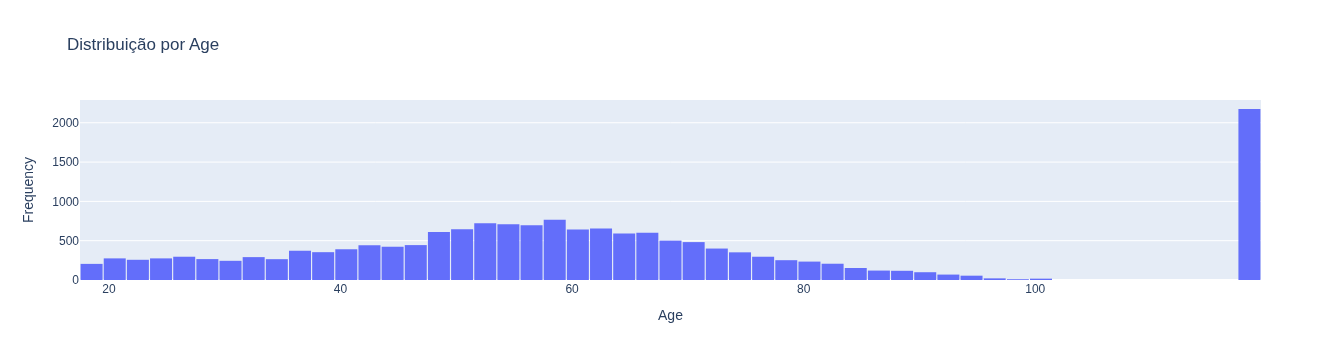

In [6]:
age_df = df_profile.select("age").toPandas()

fig = px.histogram(
    age_df,
    x="age",
    title="Distribuição por Age",
    labels={"age": "Age"},
)

fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Frequency",
    bargap=0.05,
)

fig.show()

- Existe uma certa atenção entre 40 e 75 anos
- Para as idades nulas o melhor, no momento, é distribuirde forma aleatória nas idades válidas para não estragar a distribuição

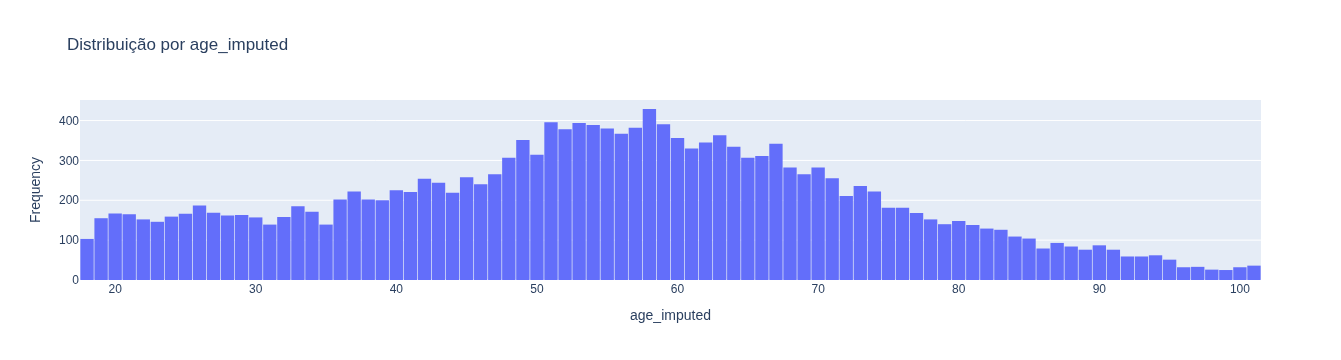

In [7]:
valid_ages = [row['age'] for row in df_profile.filter((F.col('age') != 118) & (F.col('age').isNotNull())).select('age').distinct().collect()]
df_profile = df_profile.withColumn("age_imputed", random_age_udf(F.col("age")))

age_imputed_df = df_profile.select("age_imputed").toPandas()

fig = px.histogram(
    age_imputed_df,
    x="age_imputed",
    title="Distribuição por age_imputed",
    labels={"age": "age_imputed"},
)

fig.update_layout(
    xaxis_title="age_imputed",
    yaxis_title="Frequency",
    bargap=0.05,
)

fig.show()

### Analisando Genero dos clientes

In [8]:
age_df[age_df['age']> 101]['age'].value_counts()

age
118    2175
Name: count, dtype: int64

In [9]:
df_profile.filter("age=118").select('gender').distinct().show()

+------+
|gender|
+------+
|  NULL|
+------+



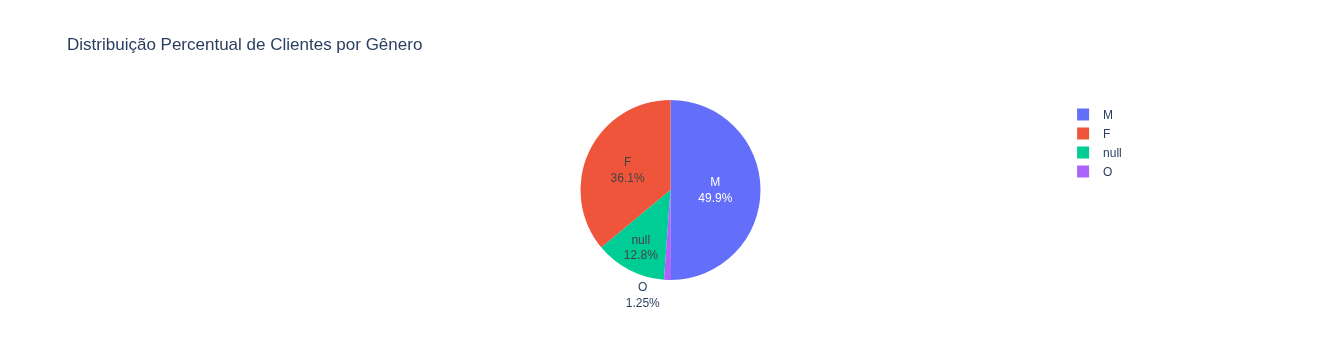

In [10]:
gender_df = df_profile.select("gender").toPandas()

fig = px.pie(
    gender_df, 
    names="gender", 
    title="Distribuição Percentual de Clientes por Gênero", 
)
fig.update_traces(textinfo="percent+label")
fig.show()

- Iremos encodar os generos não identificados em uma classe U para que mais na frente seja possivel identificar e decidir melhor o que fazer com eles
- É preciso saber se essa massa de clientes sem informações de genero é importante para as ofertas, se completam ofertas, etc

### Analisando a Distribuição de renda dos clientes

49000.0 64000.0 80000.0 105000.0


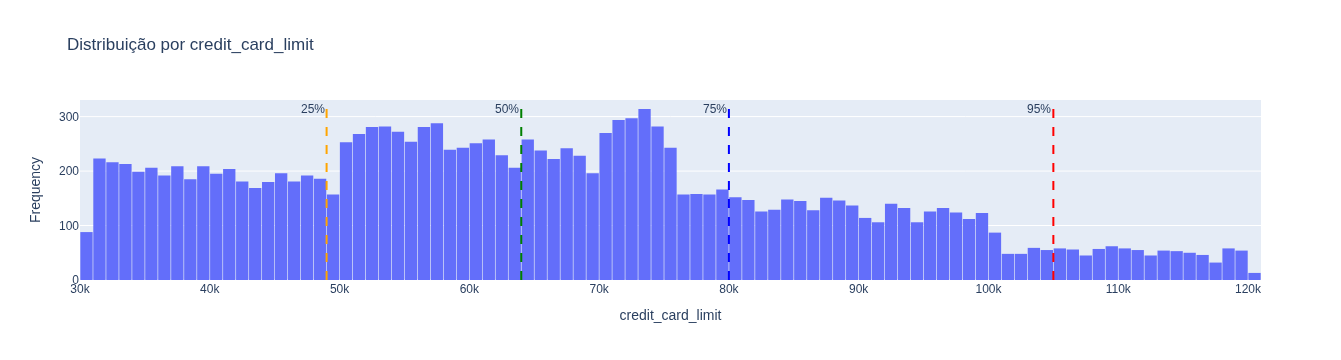

In [11]:
credit_card_limit_df = df_profile.select("credit_card_limit").toPandas()

p25 = credit_card_limit_df["credit_card_limit"].quantile(0.25)
p50 = credit_card_limit_df["credit_card_limit"].quantile(0.50)
p75 = credit_card_limit_df["credit_card_limit"].quantile(0.75)
p95 = credit_card_limit_df["credit_card_limit"].quantile(0.95)
print(p25, p50, p75, p95)

fig = px.histogram(
    credit_card_limit_df,
    x="credit_card_limit",
    title="Distribuição por credit_card_limit",
    labels={"credit_card_limit": "Limit"},
)

fig.add_vline(x=p25, line_dash="dash", line_color="orange", annotation_text="25%", annotation_position="top left")
fig.add_vline(x=p50, line_dash="dash", line_color="green", annotation_text="50%", annotation_position="top left")
fig.add_vline(x=p75, line_dash="dash", line_color="blue", annotation_text="75%", annotation_position="top left")
fig.add_vline(x=p95, line_dash="dash", line_color="red", annotation_text="95%", annotation_position="top left")


fig.update_layout(
    xaxis_title="credit_card_limit",
    yaxis_title="Frequency",
    bargap=0.05,
)

fig.show()


- Podemos quebrar as rendas em niveis
- Existe um grande numero de pessoas com renda entre 50K e 80K
- No momento a melhor opção é distribuir os valores nulos de renda de forma aleatória para as rendas validas, assim não perdemos a distribuição dos dados
- Mais pra frente podemos identifica-los pelo Genero e decidir melhor o que fazer

In [12]:
#random sampling
valid_limit = [row['credit_card_limit'] for row in df_profile.filter((F.col('credit_card_limit').isNotNull())).select('credit_card_limit').distinct().collect()]
df_profile = df_profile.withColumn("credit_card_limit_imputed", random_limit_udf(F.col("credit_card_limit")))

49000.0 65000.0 82000.0 109000.0


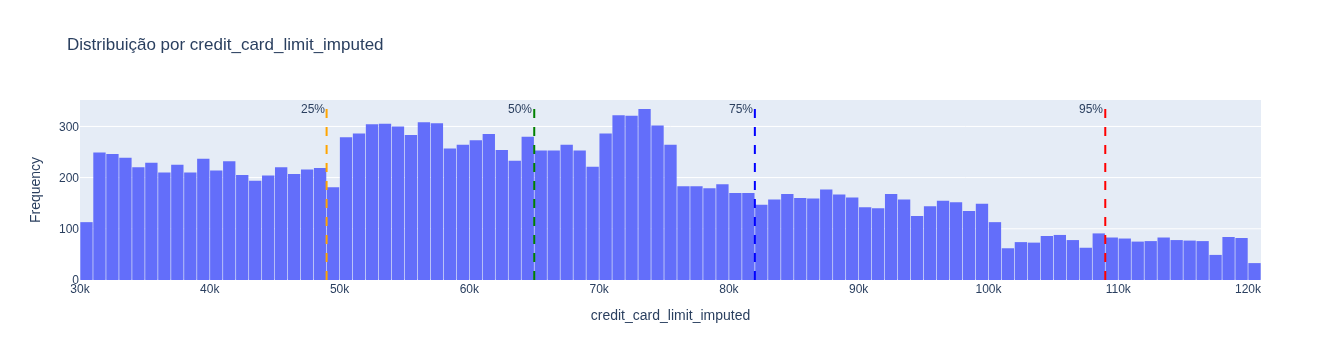

In [13]:
credit_card_limit_imputed_df = df_profile.select("credit_card_limit_imputed").toPandas()

p25 = credit_card_limit_imputed_df["credit_card_limit_imputed"].quantile(0.25)
p50 = credit_card_limit_imputed_df["credit_card_limit_imputed"].quantile(0.50)
p75 = credit_card_limit_imputed_df["credit_card_limit_imputed"].quantile(0.75)
p95 = credit_card_limit_imputed_df["credit_card_limit_imputed"].quantile(0.95)
print(p25, p50, p75, p95)

fig = px.histogram(
    credit_card_limit_imputed_df,
    x="credit_card_limit_imputed",
    title="Distribuição por credit_card_limit_imputed",
    labels={"credit_card_limit_imputed": "Limit"},
)

fig.add_vline(x=p25, line_dash="dash", line_color="orange", annotation_text="25%", annotation_position="top left")
fig.add_vline(x=p50, line_dash="dash", line_color="green", annotation_text="50%", annotation_position="top left")
fig.add_vline(x=p75, line_dash="dash", line_color="blue", annotation_text="75%", annotation_position="top left")
fig.add_vline(x=p95, line_dash="dash", line_color="red", annotation_text="95%", annotation_position="top left")


fig.update_layout(
    xaxis_title="credit_card_limit_imputed",
    yaxis_title="Frequency",
    bargap=0.05,
)

fig.show()

# Data Clean

In [15]:
df_profile.show(5, truncate=False)

+---+-------------+------+--------------------------------+-----------------+-----------+-------------------------+
|age|registered_on|gender|id                              |credit_card_limit|age_imputed|credit_card_limit_imputed|
+---+-------------+------+--------------------------------+-----------------+-----------+-------------------------+
|118|20170212     |NULL  |68be06ca386d4c31939f3a4f0e3dd783|NULL             |33         |94000                    |
|55 |20170715     |F     |0610b486422d4921ae7d2bf64640c50b|112000.0         |55         |112000                   |
|118|20180712     |NULL  |38fe809add3b4fcf9315a9694bb96ff5|NULL             |35         |83000                    |
|75 |20170509     |F     |78afa995795e4d85b5d9ceeca43f5fef|100000.0         |75         |100000                   |
|118|20170804     |NULL  |a03223e636434f42ac4c3df47e8bac43|NULL             |78         |37000                    |
+---+-------------+------+--------------------------------+-------------

##### Ajustando coluna de Genero: U 

In [16]:
df_profile = df_profile.withColumn("gender", F.when(F.col("gender").isNull(), 'U').otherwise(F.col("gender")))\
                       .withColumn("registered_on", F.to_date('registered_on', 'yyyyMMdd'))
df_profile.groupBy("gender").count().show(5, truncate=False)

+------+-----+
|gender|count|
+------+-----+
|F     |6129 |
|M     |8484 |
|U     |2175 |
|O     |212  |
+------+-----+



##### Mantendo apenas colunas imputadas

In [17]:
df_profile = df_profile.drop('credit_card_limit', 'age')\
                       .withColumnRenamed("credit_card_limit_imputed", "credit_card_limit")\
                       .withColumnRenamed("age_imputed", "age")

In [18]:
percentiles = df_profile.approxQuantile("credit_card_limit", [0.25, 0.5, 0.75, 0.95], 0.01)
p25, p50, p75, p95 = percentiles

df_profile = df_profile.withColumn("category_limite",
                                                    F.when(F.col("credit_card_limit") <= p25, 1)
                                                     .when((F.col("credit_card_limit") > p25) & (F.col("credit_card_limit") <= p50), 2)
                                                     .when((F.col("credit_card_limit") > p50) & (F.col("credit_card_limit") <= p75), 3)
                                                     .when((F.col("credit_card_limit") > p75) & (F.col("credit_card_limit") <= p95), 4)
                                                     .when(F.col("credit_card_limit") > p95, 5)
                                                )


##### Padronizando colunas

In [19]:
df_profile = df_profile.withColumnRenamed("id", "client_id")
df_profile.show(truncate=False)

+-------------+------+--------------------------------+---+-----------------+---------------+
|registered_on|gender|client_id                       |age|credit_card_limit|category_limite|
+-------------+------+--------------------------------+---+-----------------+---------------+
|2017-02-12   |U     |68be06ca386d4c31939f3a4f0e3dd783|68 |33000            |1              |
|2017-07-15   |F     |0610b486422d4921ae7d2bf64640c50b|55 |112000           |5              |
|2018-07-12   |U     |38fe809add3b4fcf9315a9694bb96ff5|48 |42000            |1              |
|2017-05-09   |F     |78afa995795e4d85b5d9ceeca43f5fef|75 |100000           |4              |
|2017-08-04   |U     |a03223e636434f42ac4c3df47e8bac43|54 |105000           |4              |
|2018-04-26   |M     |e2127556f4f64592b11af22de27a7932|68 |70000            |3              |
|2017-09-25   |U     |8ec6ce2a7e7949b1bf142def7d0e0586|31 |104000           |4              |
|2017-10-02   |U     |68617ca6246f4fbc85e91a2a49552598|66 |1

In [20]:
df_profile = df_profile.withColumn("registered_duration_days", F.datediff(F.current_date(), F.col("registered_on")))\
                       .withColumn("registered_duration_month", F.floor(F.months_between(F.current_date(), F.col("registered_on"))))\
                       .withColumn("registered_duration_years", F.floor(F.col("registered_duration_month") / 12))
df_profile.show(truncate=False)

+-------------+------+--------------------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+
|registered_on|gender|client_id                       |age|credit_card_limit|category_limite|registered_duration_days|registered_duration_month|registered_duration_years|
+-------------+------+--------------------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+
|2017-02-12   |U     |68be06ca386d4c31939f3a4f0e3dd783|62 |114000           |5              |3101                    |101                      |8                        |
|2017-07-15   |F     |0610b486422d4921ae7d2bf64640c50b|55 |112000           |5              |2948                    |96                       |8                        |
|2018-07-12   |U     |38fe809add3b4fcf9315a9694bb96ff5|64 |102000           |4              |2586                    |84                       |7

##### Criando colunas Dummies para generos

In [21]:
distinct_gender = [gd.gender for gd in df_profile.select('gender').distinct().collect()]
distinct_gender

['F', 'M', 'U', 'O']

In [22]:
for gender in distinct_gender:
    df_profile = df_profile.withColumn(f'gender_{gender}', F.when(F.col("gender") == gender, 1).otherwise(0))
df_profile.show(5, truncate=False)

+-------------+------+--------------------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+
|registered_on|gender|client_id                       |age|credit_card_limit|category_limite|registered_duration_days|registered_duration_month|registered_duration_years|gender_F|gender_M|gender_U|gender_O|
+-------------+------+--------------------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+
|2017-02-12   |U     |68be06ca386d4c31939f3a4f0e3dd783|38 |85000            |4              |3101                    |101                      |8                        |0       |0       |1       |0       |
|2017-07-15   |F     |0610b486422d4921ae7d2bf64640c50b|55 |112000           |5              |2948                    |96                       |8                        |1 

##### Criando coluna de grupo de idades de 10 em 10 anos e encondando cada grupo

In [23]:
df_profile = df_profile.withColumn("age_group", F.concat((F.floor(F.col("age") / 10) * 10).cast("int"),
                                                F.lit("-"),
                                               (F.floor(F.col("age") / 10) * 10 + 9).cast("int")
                                        ))
df_profile.show(5)

+-------------+------+--------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+---------+
|registered_on|gender|           client_id|age|credit_card_limit|category_limite|registered_duration_days|registered_duration_month|registered_duration_years|gender_F|gender_M|gender_U|gender_O|age_group|
+-------------+------+--------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+---------+
|   2017-02-12|     U|68be06ca386d4c319...| 48|            76000|              3|                    3101|                      101|                        8|       0|       0|       1|       0|    40-49|
|   2017-07-15|     F|0610b486422d4921a...| 55|           112000|              5|                    2948|                       96|                        8|       1|       0|    

In [24]:
df_age_group = df_profile.groupBy('age_group').agg(F.min('age').alias('age')).orderBy('age')\
                         .withColumn("age_group_index", F.monotonically_increasing_id())\
                         .select('age_group', 'age_group_index')
df_age_group.show(5)

+---------+---------------+
|age_group|age_group_index|
+---------+---------------+
|    10-19|              0|
|    20-29|              1|
|    30-39|              2|
|    40-49|              3|
|    50-59|              4|
+---------+---------------+
only showing top 5 rows


In [25]:
df_profile = df_profile.join(df_age_group, on='age_group', how='inner')
df_profile.show(5)

+---------+-------------+------+--------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+
|age_group|registered_on|gender|           client_id|age|credit_card_limit|category_limite|registered_duration_days|registered_duration_month|registered_duration_years|gender_F|gender_M|gender_U|gender_O|age_group_index|
+---------+-------------+------+--------------------+---+-----------------+---------------+------------------------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+
|    90-99|   2017-02-12|     U|68be06ca386d4c319...| 91|            60000|              2|                    3101|                      101|                        8|       0|       0|       1|       0|              8|
|    50-59|   2017-07-15|     F|0610b486422d4921a...| 55|           112000|              5|                    2948|

##### Salvando tabela limpa de clientes

In [26]:
df_profile = df_profile.select("client_id", "registered_on", 'registered_duration_days', 'registered_duration_month', 'registered_duration_years', 
                               "gender", 'gender_M', 'gender_F', 'gender_O', 'gender_U', "age", 'age_group', 'age_group_index', "credit_card_limit", 
                               "category_limite")
df_profile.show(5)

+--------------------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+
|           client_id|registered_on|registered_duration_days|registered_duration_month|registered_duration_years|gender|gender_M|gender_F|gender_O|gender_U|age|age_group|age_group_index|credit_card_limit|category_limite|
+--------------------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+
|68be06ca386d4c319...|   2017-02-12|                    3101|                      101|                        8|     U|       0|       0|       0|       1| 37|    30-39|              2|            49000|              1|
|0610b486422d4921a...|   2017-07-15|                    2948|                       96|                        8|   

In [101]:
df_profile.write.format("parquet").mode("overwrite").save(output_table)